In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random

import ema_workbench
from ema_workbench import (Model, RealParameter, ScalarOutcome, MultiprocessingEvaluator, ema_logging)
from ema_workbench.analysis import prim


c:\Users\ariel\anaconda3\envs\MBWSA\lib\site-packages\ema_workbench\analysis\prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive " "inspection not available"), ImportWarning)


## 1. Loading the scenario dataset

In [43]:
#loading the results from a specific set of experiments
sufficientarian_threshold = 50
full_df = pd.read_csv(f"experiment_results\ZAs_below_{sufficientarian_threshold} - 1000 scenarios - 1000nfe epsilon 1 - pozos to toluquilla 0.csv")
full_df.head(2)

,aqp4_Toluquilla_to_PP1,aqp1_PP2_to_PP3,aqp2_PP3_to_Pozos,aqp3_Pozos_to_Toluquilla,chapala_flow,calderon_lared_flow,pozos_flow,toluquilla_flow,scenario,delivered_PP1,...,supply_percapita_average,min_supplied_demand,supply_percapita_GINI,supplied_demand_GINI,average_supply_percapita,ZAs_below_142,ZAs_below_100,ZAs_below_50,scenario.1,experiment
0,0.003592,0.325899,0.108512,-0.601739,9.073719,3.849682,4.058541,0.156112,343660.0,7.349712,...,246.4,0.367,0.334416,0.327881,245.0,1.0,1.0,0.0,343660.0,ZAs_below_50 - 1000 scenarios - 1000nfe epsilo...
1,-0.556724,-0.750691,-0.635549,-0.097600,8.654988,1.304894,2.469831,0.078252,387278.0,7.010540,...,184.0,0.751,0.162174,0.162077,178.0,1.0,0.0,0.0,387278.0,ZAs_below_50 - 1000 scenarios - 1000nfe epsilo...


In [45]:


#Defining what optimizations will be explored
sufficientarian_threshold = 100

#loading the results from a specific set of experiments
full_df = pd.read_csv(f"experiment_results\ZAs_below_{sufficientarian_threshold} - 1000 scenarios - 1000nfe epsilon 1 - pozos to toluquilla 0.csv")

#loading the results from the 50l/day/person 1000 scenarios with restriction optimization
prim_df = full_df
#prim_df = pd.read_csv("experiment_results\ZAs_below_50  - 1000 scenarios - 1000nfe epsilon 1 - pozos to toluquilla 0.csv", index_col = [0])

#Create a new column with False for the scenarios where there's no solution that can ensure that all ZA are above the sufficientarian threshold
variable_of_interest = f"ZAs_below_{sufficientarian_threshold}"
prim_df["scenario_of_interest"] = prim_df[variable_of_interest] == 0

all_columns = prim_df.columns
print(all_columns)

Index(['aqp4_Toluquilla_to_PP1', 'aqp1_PP2_to_PP3', 'aqp2_PP3_to_Pozos',
       'aqp3_Pozos_to_Toluquilla', 'chapala_flow', 'calderon_lared_flow',
       'pozos_flow', 'toluquilla_flow', 'scenario', 'delivered_PP1',
       'delivered_PP2', 'delivered_PP3', 'delivered_Toluquilla',
       'delivered_Pozos', 'supplied_PP1', 'supplied_PP2', 'supplied_PP3',
       'supplied_Toluquilla', 'supplied_Pozos', 'total_supplied', 'demand_PP1',
       'demand_PP2', 'demand_PP3', 'demand_Toluquilla', 'demand_Pozos',
       'supplied_demand_PP1', 'supplied_demand_PP2', 'supplied_demand_PP3',
       'supplied_demand_Toluquilla', 'supplied_demand_Pozos',
       'supplied_demand_deficit_PP1', 'supplied_demand_deficit_PP2',
       'supplied_demand_deficit_PP3', 'supplied_demand_deficit_Toluquilla',
       'supplied_demand_deficit_Pozos', 'supply_percapita_PP1',
       'supply_percapita_PP2', 'supply_percapita_PP3',
       'supply_percapita_Toluquilla', 'supply_percapita_Pozos',
       'supplied_demand_ave

## Logistic regression

### Old experiments

In [66]:
#old experiments
import statsmodels.api as sm
import numpy as np
import pandas as pd

log_reg_results = {}
dataframes = {}


for threshold in [50, 100, 128]:
    full_df = pd.read_csv(f"old_experiments/ZAs_below_{threshold}  - 1000 scenarios - 1000nfe epsilon 1 - pozos to toluquilla 0.csv")
    #loading the results from the 50l/day/person 1000 scenarios with restriction optimization
    log_reg_df = full_df

    #Create a new column with False for the scenarios where there's no solution that can ensure that all ZA are above the sufficientarian threshold
    variable_of_interest = f"ZAs_below_{threshold}"
    log_reg_df["scenario_of_interest"] = log_reg_df[variable_of_interest] > 0

    log_reg_df=log_reg_df.loc[:][:][['chapala_flow', 'calderon_flow',
        'pozos_flow', "zapotillo_flow", 'toluquilla_flow',"scenario_of_interest"]]
    
    dataframes = {threshold:log_reg_df}

    log_reg_df["intercept"] = np.ones(np.shape(log_reg_df)[0])
    predictors = ['chapala_flow', 'calderon_flow', 'pozos_flow', "zapotillo_flow", 'toluquilla_flow', 'intercept']

    logit = sm.Logit(log_reg_df["scenario_of_interest"], log_reg_df[predictors])
    log_reg_results[threshold] = logit.fit()


def predict_scenario(scenario,threshold):
    # Add an intercept term
    scenario['intercept'] = 1

    # Predict the probability of the scenario being of interest
    scenario_array = np.array([scenario[col] for col in predictors])
    log_odds = np.dot(log_reg_results[threshold].params, scenario_array)
    probability = 1 / (1 + np.exp(-log_odds))
    
    return probability

Optimization terminated successfully.
         Current function value: 0.034219
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.146963
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.052838
         Iterations 12


In [67]:
new_scenario = {
    'chapala_flow': 0.3,
    'calderon_flow': 0.0,
    'pozos_flow': 8,
    "zapotillo_flow":0, 
    'toluquilla_flow': 0.0
}
probability_threshold = 0.5
sufficientarian_thresholds = [50, 100, 128]

for threshold in sufficientarian_thresholds:
    likelihood = predict_scenario(new_scenario, threshold) 

    print(f"The likelihood that at least one ZA will fall below {threshold}l/day/person under this scenario is : {likelihood:.2f}")

for threshold in sufficientarian_thresholds:
    likelihood = predict_scenario(new_scenario, threshold)
    
    if likelihood>= probability_threshold:
        if threshold == 50: 
            print("Thus, the current drought state is considered HIGH drought")
            break
        elif threshold == 100: 
            print("Thus, the current drought state is considered  MID drought")
            break
        elif threshold == 128:
            print("Thus, the current drought state is considered LOW drought")
            break
    if threshold == 128: print("Thus, the current drought state is considered NO drought")
        

The likelihood that at least one ZA will fall below 50l/day/person under this scenario is : 1.00
The likelihood that at least one ZA will fall below 100l/day/person under this scenario is : 0.49
The likelihood that at least one ZA will fall below 128l/day/person under this scenario is : 0.98
Thus, the current drought state is considered HIGH drought


In [72]:
scarcity_indicator_validation_df = pd.DataFrame()

for indicator in ["ZAs_below_50", "ZAs_below_100", "ZAs_below_128"]:

    validation_df = pd.read_csv(f"old_experiments\{indicator}  - 1000 scenarios - 1000nfe epsilon 1 - pozos to toluquilla 0.csv")
    validation_df = validation_df.loc[:][['chapala_flow', 'calderon_flow', 'pozos_flow', "zapotillo_flow", 'toluquilla_flow', 'ZAs_below_50',"ZAs_below_100", "ZAs_below_128"]]
    validation_df["drought_state"] = ""
    for index, row in validation_df.iterrows():


        scenario = row[['chapala_flow', 'calderon_flow', 'zapotillo_flow', 'pozos_flow', 'toluquilla_flow']].to_dict()
        probability_threshold = 0.5
        sufficientarian_thresholds = [50, 100, 128]
        drought_state = ""
        for threshold in sufficientarian_thresholds:
            likelihood = predict_scenario(scenario, threshold)
            
            if likelihood> probability_threshold:
                if threshold == 50: 
                    drought_state="high drought"
                    break
                elif threshold == 100: 
                    drought_state="mid-drought"
                    break
                elif threshold == 128:
                    drought_state="low drought"
                    break
            if threshold == 128: drought_state="no_drought"
        
        validation_df["drought_state"][index]=drought_state
        validation_df["optimization"] = indicator


    scarcity_indicator_validation_df = pd.concat([scarcity_indicator_validation_df, validation_df], axis = 0)
    scarcity_indicator_validation_df.to_clipboard()

C:\Users\ariel\AppData\Local\Temp\ipykernel_25216\1033482298.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df["drought_state"][index]=drought_state


### New experiments

In [80]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

log_reg_results = {}
dataframes = {}



for threshold in [50, 100, 142]:
    full_df = pd.read_csv(f"experiment_results\ZAs_below_{threshold} - 1000 scenarios - 1000nfe epsilon 1 - pozos to toluquilla 0.csv")
    #loading the results from the 50l/day/person 1000 scenarios with restriction optimization
    log_reg_df = full_df

    #Create a new column with False for the scenarios where there's no solution that can ensure that all ZA are above the sufficientarian threshold
    variable_of_interest = f"ZAs_below_{threshold}"
    log_reg_df["scenario_of_interest"] = log_reg_df[variable_of_interest] > 0

    log_reg_df=log_reg_df.loc[:][:][['chapala_flow', 'calderon_lared_flow',
        'pozos_flow', 'toluquilla_flow',"scenario_of_interest"]]
    
    dataframes = {threshold:log_reg_df}

    log_reg_df["intercept"] = np.ones(np.shape(log_reg_df)[0])
    predictors = ['chapala_flow', 'calderon_lared_flow', 'pozos_flow', 'toluquilla_flow', 'intercept']

    logit = sm.Logit(log_reg_df["scenario_of_interest"], log_reg_df[predictors])
    log_reg_results[threshold] = logit.fit()


def predict_scenario(scenario,threshold):
    # Add an intercept term
    scenario['intercept'] = 1

    # Predict the probability of the scenario being of interest
    scenario_array = np.array([scenario[col] for col in predictors])
    log_odds = np.dot(log_reg_results[threshold].params, scenario_array)
    probability = 1 / (1 + np.exp(-log_odds))
    
    return probability





Optimization terminated successfully.
         Current function value: 0.017697
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.117145
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.158112
         Iterations 9


In [83]:
print(log_reg_results[142].summary2())

                            Results: Logit
Model:              Logit                Method:           MLE        
Dependent Variable: scenario_of_interest Pseudo R-squared: 0.769      
Date:               2024-06-05 00:43     AIC:              326.2247   
No. Observations:   1000                 BIC:              350.7635   
Df Model:           4                    Log-Likelihood:   -158.11    
Df Residuals:       995                  LL-Null:          -683.31    
Converged:          1.0000               LLR p-value:      4.2519e-226
No. Iterations:     9.0000               Scale:            1.0000     
----------------------------------------------------------------------
                       Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------
chapala_flow          -1.7980   0.1437 -12.5168 0.0000 -2.0796 -1.5165
calderon_lared_flow   -0.8567   0.1319  -6.4948 0.0000 -1.1153 -0.5982
pozos_flow            -1.1654   0.

In [74]:


new_scenario = {
    'chapala_flow': 11.3,
    'calderon_lared_flow': 0.1,
    'pozos_flow': 0.3,
    'toluquilla_flow': 0.8
}
probability_threshold = 0.5
sufficientarian_thresholds = [50, 100, 142]

for threshold in sufficientarian_thresholds:
    likelihood = predict_scenario(new_scenario, threshold) 

    print(f"The likelihood that at least one ZA will fall below {threshold}l/day/person under this scenario is : {likelihood:.2f}")

for threshold in sufficientarian_thresholds:
    likelihood = predict_scenario(new_scenario, threshold)
    
    if likelihood>= probability_threshold:
        if threshold == 50: 
            print("Thus, the current drought state is considered HIGH drought")
            break
        elif threshold == 100: 
            print("Thus, the current drought state is considered  MID drought")
            break
        elif threshold == 142:
            print("Thus, the current drought state is considered LOW drought")
            break
    if threshold == 142: print("Thus, the current drought state is considered NO drought")
        

The likelihood that at least one ZA will fall below 50l/day/person under this scenario is : 0.00
The likelihood that at least one ZA will fall below 100l/day/person under this scenario is : 0.00
The likelihood that at least one ZA will fall below 142l/day/person under this scenario is : 0.02
Thus, the current drought state is considered NO drought


#### Validation

In [79]:
scarcity_indicator_validation_df = pd.DataFrame()

for indicator in ["ZAs_below_50", "ZAs_below_100", "ZAs_below_142"]:

    validation_df = pd.read_csv(f"experiment_results\{indicator} - 1000 scenarios - 1000nfe epsilon 1 - pozos to toluquilla 0.csv")
    validation_df = validation_df.loc[:][['chapala_flow', 'calderon_lared_flow', 'pozos_flow', 'toluquilla_flow', 'ZAs_below_50',"ZAs_below_100", "ZAs_below_142"]]
    validation_df["drought_state"] = ""
    validation_df["probability"] = ""
    for index, row in validation_df.iterrows():


        scenario = row[['chapala_flow', 'calderon_lared_flow', 'pozos_flow', 'toluquilla_flow']].to_dict()
        probability_threshold = 0.5
        sufficientarian_thresholds = [50, 100, 142]
        drought_state = ""
        for threshold in sufficientarian_thresholds:
            likelihood = predict_scenario(scenario, threshold)
            
            if likelihood> probability_threshold:
                if threshold == 50: 
                    drought_state="high drought"
                    validation_df["probability"][index] = likelihood
                    break
                elif threshold == 100: 
                    drought_state="mid-drought"
                    validation_df["probability"][index] = likelihood
                    break
                elif threshold == 142:
                    drought_state="low drought"
                    validation_df["probability"][index] = likelihood
                    break
            if threshold == 142: 
                drought_state="no_drought"
                validation_df["probability"][index] = likelihood
        
        validation_df["drought_state"][index]=drought_state
        validation_df["optimization"] = indicator


    scarcity_indicator_validation_df = pd.concat([scarcity_indicator_validation_df, validation_df], axis = 0)
    scarcity_indicator_validation_df.to_clipboard()



C:\Users\ariel\AppData\Local\Temp\ipykernel_25216\888742846.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df["probability"][index] = likelihood
C:\Users\ariel\AppData\Local\Temp\ipykernel_25216\888742846.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_df["drought_state"][index]=drought_state
C:\Users\ariel\AppData\Local\Temp\ipykernel_25216\888742846.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 

C:\Users\ariel\AppData\Local\Temp\ipykernel_25216\4266625827.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dta['Intercept'] = np.ones(np.shape(dta)[0])
C:\Users\ariel\AppData\Local\Temp\ipykernel_25216\4266625827.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  contour_cmap = mpl.cm.get_cmap('RdBu')


Optimization terminated successfully.
         Current function value: 0.134102
         Iterations 10
                            Logit Regression Results                            
Dep. Variable:     scenario_of_interest   No. Observations:                  667
Model:                            Logit   Df Residuals:                      663
Method:                             MLE   Df Model:                            3
Date:                  Tue, 04 Jun 2024   Pseudo R-squ.:                  0.7220
Time:                          23:01:33   Log-Likelihood:                -89.446
converged:                         True   LL-Null:                       -321.79
Covariance Type:              nonrobust   LLR p-value:                2.146e-100
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             -22.4957      2.561     -8.785      0.000     -27.5

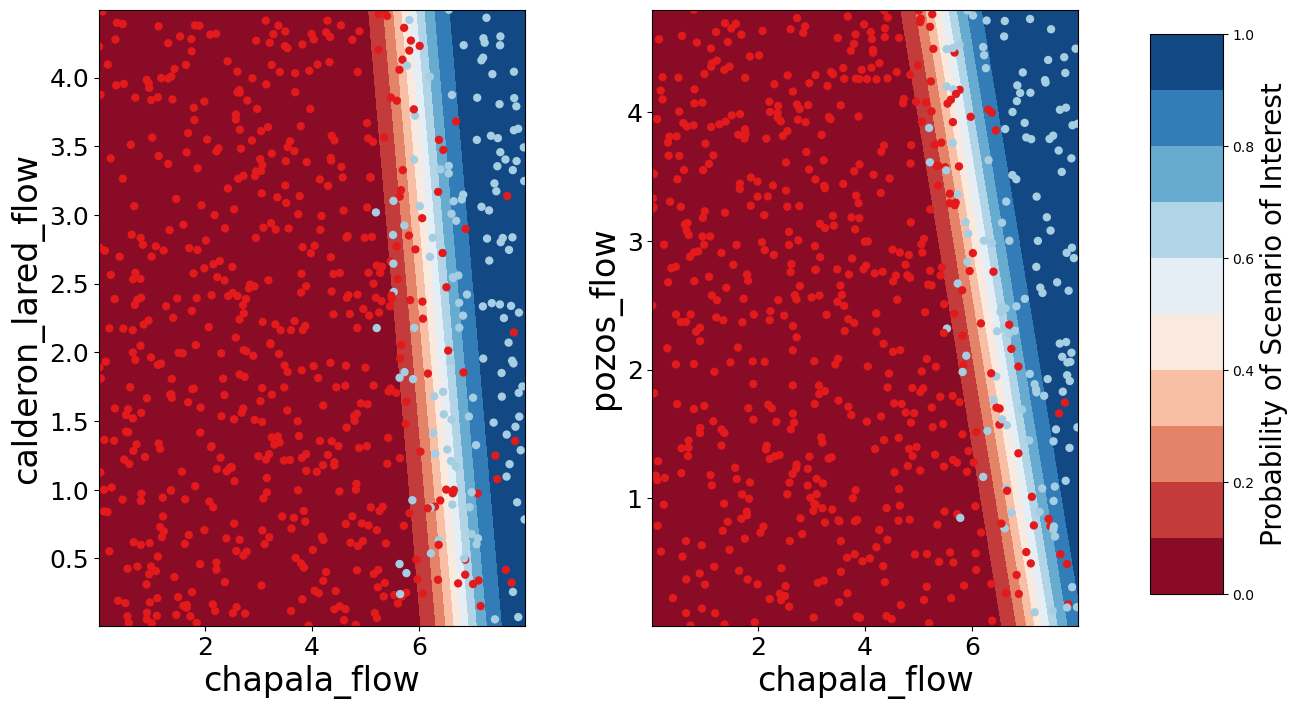

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm

# Load the data
threshold = 142
full_df = pd.read_csv(f"experiment_results/ZAs_below_{threshold} - 1000 scenarios - 1000nfe epsilon 1 - pozos to toluquilla 0.csv")

# Filter the data
log_reg_df = full_df.loc[full_df["chapala_flow"] < 8][:]

# Define the variable of interest
variable_of_interest = f"ZAs_below_{threshold}"
log_reg_df["scenario_of_interest"] = log_reg_df[variable_of_interest] == 0

# Define the predictors and target
predictors = ["chapala_flow", 'calderon_lared_flow', 'pozos_flow']
target = 'scenario_of_interest'
dta = log_reg_df[predictors + [target]]

# Fit the logistic regression model
def fitLogit(dta, predictors):
    dta['Intercept'] = np.ones(np.shape(dta)[0])
    cols = ['Intercept'] + predictors
    logit = sm.Logit(dta[target], dta[cols])
    result = logit.fit()
    return result

result = fitLogit(dta, predictors)
print(result.summary())

# Define the contour plot function
def plotContourMap(ax, result, constant, dta, contour_cmap, dot_cmap, levels, xgrid, ygrid, xvar, yvar, base):
    X, Y = np.meshgrid(xgrid, ygrid)
    x = X.flatten()
    y = Y.flatten()

    if constant == 'pozos_flow':  # pozos_flow predictor held constant at base value
        grid = np.column_stack([np.ones(len(x)), x, y, np.ones(len(x)) * base[2]])
    elif constant == 'calderon_lared_flow':  # calderon_lared_flow predictor held constant at base value
        grid = np.column_stack([np.ones(len(x)), x, np.ones(len(x)) * base[1], y])
    else:  # chapala_flow predictor held constant at base value
        grid = np.column_stack([np.ones(len(x)), np.ones(len(x)) * base[0], x, y])

    z = result.predict(grid)
    Z = np.reshape(z, np.shape(X))

    contourset = ax.contourf(X, Y, Z, levels, cmap=contour_cmap)
    ax.scatter(dta[xvar].values, dta[yvar].values, c=dta[target].values, edgecolor='none', cmap=dot_cmap)
    ax.set_xlim(np.min(X), np.max(X))
    ax.set_ylim(np.min(Y), np.max(Y))
    ax.set_xlabel(xvar, fontsize=24)
    ax.set_ylabel(yvar, fontsize=24)
    ax.tick_params(axis='both', labelsize=18)

    return contourset

# Define color maps and levels
dot_cmap = mpl.colors.ListedColormap(np.array([[227, 26, 28], [166, 206, 227]]) / 255.0)
contour_cmap = mpl.cm.get_cmap('RdBu')
contour_levels = np.arange(0.0, 1.05, 0.1)

# Define the grid for the predictors based on data limits
xgrid = np.linspace(log_reg_df[predictors[0]].min(), log_reg_df[predictors[0]].max(), 100)
ygrid = np.linspace(log_reg_df[predictors[1]].min(), log_reg_df[predictors[1]].max(), 100)
zgrid = np.linspace(log_reg_df[predictors[2]].min(), log_reg_df[predictors[2]].max(), 100)
base = [log_reg_df[predictors[0]].mean(), log_reg_df[predictors[1]].mean(), log_reg_df[predictors[2]].mean()]

# Create the plots
fig = plt.figure()
ax = fig.add_subplot(121)
plotContourMap(ax, result, 'pozos_flow', dta, contour_cmap, dot_cmap, contour_levels, xgrid, ygrid, predictors[0], predictors[1], base)
ax = fig.add_subplot(122)
contourset = plotContourMap(ax, result, 'calderon_lared_flow', dta, contour_cmap, dot_cmap, contour_levels, xgrid, zgrid, predictors[0], predictors[2], base)

# Adjust subplot spacing and add colorbar
fig.subplots_adjust(wspace=0.3, hspace=0.3, right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(contourset, cax=cbar_ax)
cbar_ax.set_ylabel('Probability of Scenario of Interest', fontsize=20)
fig.set_size_inches([14.5, 8])
plt.show()



In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm

# Load the data
threshold = 142
full_df = pd.read_csv(f"experiment_results/ZAs_below_{threshold} - 1000 scenarios - 1000nfe epsilon 1 - pozos to toluquilla 0.csv")

# Filter the data
log_reg_df = full_df.loc[full_df["chapala_flow"] < 8][:]

# Define the variable of interest
variable_of_interest = f"ZAs_below_{threshold}"
log_reg_df["scenario_of_interest"] = log_reg_df[variable_of_interest] == 0

# Define the predictors and target
predictors = ["chapala_flow", 'calderon_lared_flow', 'pozos_flow', 'toluquilla_flow']
target = 'scenario_of_interest'
dta = log_reg_df[predictors + [target]]

# Fit the logistic regression model
def fitLogit(dta, predictors):
    dta['Intercept'] = np.ones(np.shape(dta)[0])
    cols = ['Intercept'] + predictors
    logit = sm.Logit(dta[target], dta[cols])
    result = logit.fit()
    return result

result = fitLogit(dta, predictors)
print(result.summary())

# Define the contour plot function
def plotContourMap(ax, result, constant, dta, contour_cmap, dot_cmap, levels, xgrid, ygrid, xvar, yvar, base):
    X, Y = np.meshgrid(xgrid, ygrid)
    x = X.flatten()
    y = Y.flatten()

    if constant == 'pozos_flow':  # pozos_flow predictor held constant at base value
        grid = np.column_stack([np.ones(len(x)), x, y, np.ones(len(x)) * base[2], np.ones(len(x)) * base[3], np.ones(len(x)) * base[4]])
    elif constant == 'calderon_lared_flow':  # calderon_lared_flow predictor held constant at base value
        grid = np.column_stack([np.ones(len(x)), x, np.ones(len(x)) * base[1], y, np.ones(len(x)) * base[3], np.ones(len(x)) * base[4]])
    elif constant == 'toluquilla_flow':  # toluquilla_flow predictor held constant at base value
        grid = np.column_stack([np.ones(len(x)), x, np.ones(len(x)) * base[1], np.ones(len(x)) * base[2], y, np.ones(len(x)) * base[4]])
    else:  # chapala_flow predictor held constant at base value
        grid = np.column_stack([np.ones(len(x)), np.ones(len(x)) * base[0], x, y, np.ones(len(x)) * base[3], np.ones(len(x)) * base[4]])

    z = result.predict(grid)
    Z = np.reshape(z, np.shape(X))

    contourset = ax.contourf(X, Y, Z, levels, cmap=contour_cmap)
    ax.scatter(dta[xvar].values, dta[yvar].values, c=dta[target].values, edgecolor='none', cmap=dot_cmap)
    ax.set_xlim(np.min(X), np.max(X))
    ax.set_ylim(np.min(Y), np.max(Y))
    ax.set_xlabel(xvar, fontsize=24)
    ax.set_ylabel(yvar, fontsize=24)
    ax.tick_params(axis='both', labelsize=18)

    return contourset

# Define color maps and levels
dot_cmap = mpl.colors.ListedColormap(np.array([[227, 26, 28], [166, 206, 227]]) / 255.0)
contour_cmap = mpl.cm.get_cmap('RdBu')
contour_levels = np.arange(0.0, 1.05, 0.1)

# Define the grid for the predictors based on data limits
xgrid = np.linspace(log_reg_df[predictors[0]].min(), log_reg_df[predictors[0]].max(), 100)
ygrid = np.linspace(log_reg_df[predictors[1]].min(), log_reg_df[predictors[1]].max(), 100)
zgrid = np.linspace(log_reg_df[predictors[2]].min(), log_reg_df[predictors[2]].max(), 100)
tgrid = np.linspace(log_reg_df[predictors[3]].min(), log_reg_df[predictors[3]].max(), 100)
ugrid = np.linspace(log_reg_df[predictors[4]].min(), log_reg_df[predictors[4]].max(), 100)
base = [log_reg_df[predictors[0]].mean(), log_reg_df[predictors[1]].mean(), log_reg_df[predictors[2]].mean(), log_reg_df[predictors[3]].mean(), log_reg_df[predictors[4]].mean()]

# Create the plots
fig = plt.figure(figsize=(18, 12))

# First subplot
ax = fig.add_subplot(231)
plotContourMap(ax, result, 'pozos_flow', dta, contour_cmap, dot_cmap, contour_levels, xgrid, ygrid, predictors[0], predictors[1], base)

# Second subplot
ax = fig.add_subplot(232)
plotContourMap(ax, result, 'calderon_lared_flow', dta, contour_cmap, dot_cmap, contour_levels, xgrid, zgrid, predictors[0], predictors[2], base)

# Third subplot
ax = fig.add_subplot(233)
plotContourMap(ax, result, 'toluquilla_flow', dta, contour_cmap, dot_cmap, contour_levels, xgrid, tgrid, predictors[0], predictors[3], base)

# Fourth subplot
ax = fig.add_subplot(234)
plotContourMap(ax, result, 'zapotillo_flow', dta, contour_cmap, dot_cmap, contour_levels, xgrid, ugrid, predictors[0], predictors[4], base)

# Fifth subplot
ax = fig.add_subplot(235)
plotContourMap(ax, result, 'toluquilla_flow', dta, contour_cmap, dot_cmap, contour_levels, ygrid, zgrid, predictors[1], predictors[2], base)

# Adjust subplot spacing and add colorbar
fig.subplots_adjust(wspace=0.4, hspace=0.4, right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
cbar = fig.colorbar(contourset, cax=cbar_ax)
cbar_ax.set_ylabel('Probability of Scenario of Interest', fontsize=20)

plt.show()


KeyError: "['zapotillo_flow'] not in index"

Index(['aqp1_PP2_to_PP3', 'aqp2_PP3_to_Pozos', 'aqp3_Pozos_to_Toluquilla',
       'chapala_flow', 'calderon_flow', 'zapotillo_flow', 'pozos_flow',
       'toluquilla_flow', 'scenario', 'delivered_PP1', 'delivered_PP2',
       'delivered_PP3', 'delivered_Toluquilla', 'delivered_Pozos',
       'supplied_PP1', 'supplied_PP2', 'supplied_PP3', 'supplied_Toluquilla',
       'supplied_Pozos', 'total_supplied', 'demand_PP1', 'demand_PP2',
       'demand_PP3', 'demand_Toluquilla', 'demand_Pozos',
       'supplied_demand_PP1', 'supplied_demand_PP2', 'supplied_demand_PP3',
       'supplied_demand_Toluquilla', 'supplied_demand_Pozos',
       'supplied_demand_deficit_PP1', 'supplied_demand_deficit_PP2',
       'supplied_demand_deficit_PP3', 'supplied_demand_deficit_Toluquilla',
       'supplied_demand_deficit_Pozos', 'supply_percapita_PP1',
       'supply_percapita_PP2', 'supply_percapita_PP3',
       'supply_percapita_Toluquilla', 'supply_percapita_Pozos',
       'min_supplied_demand', 'supplied_d